In [2]:
import sys
from datetime import datetime
from pathlib import Path

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed

sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, load_state_npz, MeasurementDataset, MeasurementLoader
from hyper_rbm import SymmetricHyperRBM, train_loop, get_sigmoid_curve, save_model
from wavefunction_overlap import generate_basis_states, calculate_exact_overlap, load_gt_wavefunction

data_dir = Path("measurements")
state_dir = Path("state_vectors")
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

device = "cpu"
print(f"Running on: {device}")
SIDE_LENGTH = 4
FILE_SAMPLE_COUNT = 20_000
TRAIN_SAMPLE_COUNT = 20_000

# h_support = [1.00, 1.10, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50]
# h_support = [1.0, 2.00, 3.0, 4.00, 5.0] # traing on 20260121_...
# h_support = [0.5, 1.0, 1.5, 2.00, 2.5, 3.0, 3.5, 4.00, 4.5, 5.0] # golden
h_support = [1.0, 1.1, 1.5, 2.00, 2.5, 3.0, 3.5, 4.00, 4.5]
# h_novel = [2.80, 3.20]
# h_novel = [1.1, 1.5, 2.1, 2.5, 2.8, 3.2, 3.3, 3.5, 3.6, 4.5, 5, 5.5]
h_novel = [2.1, 2.8, 3.2, 3.3, 3.6, 5, 5.5]
all_h_values = sorted(list(set(h_support + h_novel)))

file_names = [f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h:.2f}_{FILE_SAMPLE_COUNT}.npz" for h in h_support]
file_paths = [data_dir / fn for fn in file_names]

print(f"Support points: {h_support}")
print(f"Training on {TRAIN_SAMPLE_COUNT} samples per support point.")

samples_per_support = [TRAIN_SAMPLE_COUNT] * len(file_paths)
dataset = MeasurementDataset(file_paths, load_measurements_npz, ["h"], samples_per_support)
N_EPOCHS = 50
BATCH_SIZE = 1024
NUM_HIDDEN = 64
HYPER_NET_WIDTH = 64
K_STEPS = 20
# K_STEPS = 15
GIBBS_NOISE_FRAC = 0.1
INIT_LR = 1e-2
FINAL_LR = 1e-4

all_seeds = np.arange(20) + 42

def train_and_eval_seed(seed):
    seed = int(seed)
    print(f"Training model with seed {seed}...")
    torch.manual_seed(seed)
    rng = torch.Generator().manual_seed(seed)

    loader = MeasurementLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, rng=rng)

    model = SymmetricHyperRBM(num_v=dataset.num_qubits, num_h=NUM_HIDDEN, hyper_dim=HYPER_NET_WIDTH, k=K_STEPS).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=INIT_LR)
    scheduler = get_sigmoid_curve(INIT_LR, FINAL_LR, N_EPOCHS*len(loader), 0.005)

    model = train_loop(model, optimizer, loader, num_epochs=N_EPOCHS, lr_schedule_fn=scheduler, noise_frac=GIBBS_NOISE_FRAC, rng=rng)

    all_states = generate_basis_states(dataset.num_qubits, device)
    h_support_arr = np.asarray(h_support)

    overlap_rows = []
    for h_val in all_h_values:
        gt_path = state_dir / f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h_val:.2f}.npz"
        psi_true = load_gt_wavefunction(gt_path, device)

        overlap = calculate_exact_overlap(model, h_val, psi_true, all_states)
        split = "support" if np.isclose(h_support_arr, h_val, atol=1e-3).any() else "novel"

        overlap_rows.append({"h": float(h_val), "overlap": float(overlap), "split": split, "seed": int(seed)})
        print(f"h={h_val:.2f} ({split:7}) | Overlap = {overlap:.5f}")

    overlap_df = pd.DataFrame(overlap_rows)

    # Save model with seed in filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"hyprbm_tfim_4x4_{TRAIN_SAMPLE_COUNT}_suscept_seed{seed}_{timestamp}.pt"
    save_path = models_dir / filename

    config = { "train_samples": TRAIN_SAMPLE_COUNT, "epochs": N_EPOCHS, "h_support": h_support, "seed": int(seed) }
    save_model(model, config, overlap_rows, save_path)

    return overlap_df

# Parallel execution over seeds
all_fidelities = Parallel(n_jobs=4)(delayed(train_and_eval_seed)(seed) for seed in all_seeds)

Running on: cpu
Support points: [1.0, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]
Training on 20000 samples per support point.


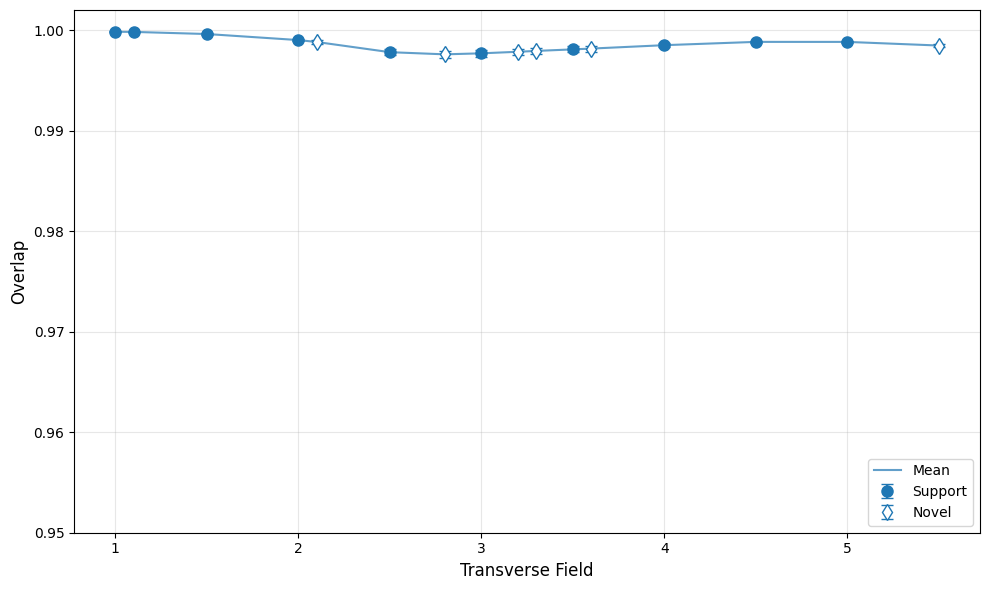

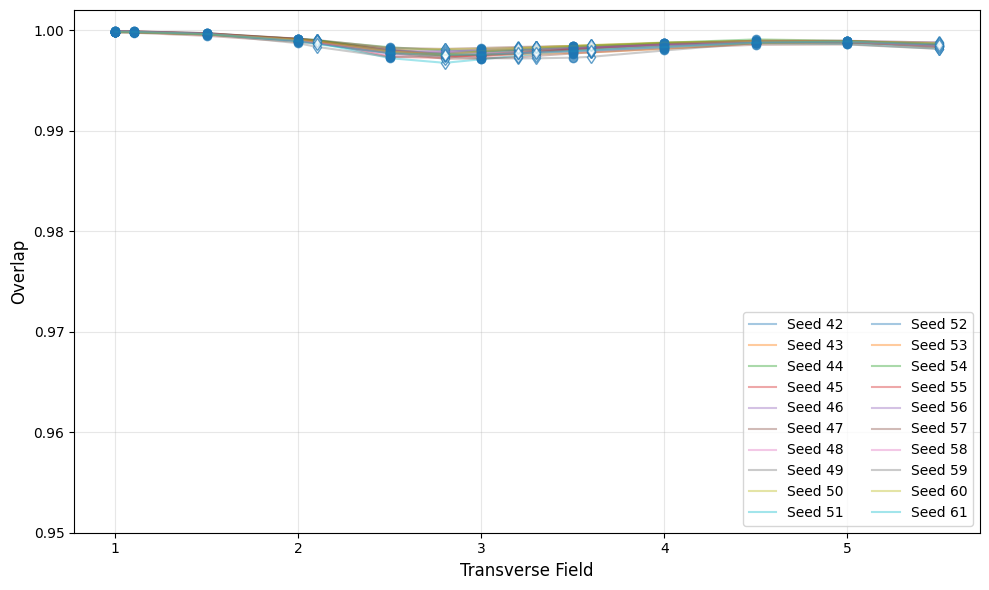

In [6]:
# --- Aggregate and plot results ---
# Concatenate all results
all_fid_df = pd.concat(all_fidelities, ignore_index=True)

# Pivot to get mean and std for each h
grouped = all_fid_df.groupby(["h", "split"])["overlap"]
mean_fid = grouped.mean().reset_index()
std_fid = grouped.std().reset_index()

# Plot mean with error bars and markers for support/novel
# One line through all points, markers indicate split
plt.figure(figsize=(10, 6), dpi=100)
# Sort by h for plotting
mean_fid_sorted = mean_fid.sort_values("h")
std_fid_sorted = std_fid.sort_values("h")
for idx, row in mean_fid_sorted.iterrows():
    h = row["h"]
    y = row["overlap"]
    yerr = std_fid_sorted[(std_fid_sorted["h"] == h) & (std_fid_sorted["split"] == row["split"])]["overlap"].values[0]
    if row["split"] == "support":
        plt.errorbar(h, y, yerr=yerr, fmt='o', color='tab:blue', markersize=8, markerfacecolor='tab:blue', markeredgecolor='tab:blue', capsize=4, label="Support" if idx == mean_fid_sorted[mean_fid_sorted["split"]=="support"].index[0] else "")
    else:
        plt.errorbar(h, y, yerr=yerr, fmt='d', color='tab:blue', markersize=8, markerfacecolor='white', markeredgecolor='tab:blue', capsize=4, label="Novel" if idx == mean_fid_sorted[mean_fid_sorted["split"]=="novel"].index[0] else "")
# Draw a line through all mean points (regardless of split)
plt.plot(mean_fid_sorted["h"], mean_fid_sorted["overlap"], '-', color='tab:blue', alpha=0.7, zorder=0, label="Mean")
plt.xlabel(r"Transverse Field", fontsize=12)
plt.ylabel(r"Overlap", fontsize=12)
plt.ylim(0.95, 1.002)
plt.grid(True, alpha=0.3)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower right", fontsize=10)
plt.tight_layout()
plt.show()

# --- Plot all seeds individually ---
plt.figure(figsize=(10, 6), dpi=100)
for seed in all_fid_df["seed"].unique():
    df = all_fid_df[all_fid_df["seed"] == seed].sort_values("h")
    # Plot line through all points for this seed
    plt.plot(df["h"], df["overlap"], '-', alpha=0.4, label=f"Seed {seed}")
    # Plot support and novel markers
    support = df[df["split"] == "support"]
    novel = df[df["split"] == "novel"]
    plt.plot(support["h"], support["overlap"], 'o', color='tab:blue', markersize=6, markerfacecolor='tab:blue', markeredgecolor='tab:blue', alpha=0.7)
    plt.plot(novel["h"], novel["overlap"], 'd', color='tab:blue', markersize=6, markerfacecolor='white', markeredgecolor='tab:blue', alpha=0.7)
plt.xlabel(r"Transverse Field", fontsize=12)
plt.ylabel(r"Overlap", fontsize=12)
plt.ylim(0.95, 1.002)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right", fontsize=10, ncol=2)
plt.tight_layout()
plt.show()